<a href="https://colab.research.google.com/github/valesierrai/Aprendizaje-No-Supervisado-para-el-AD/blob/main/HC_accidentes_medellin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



En la ciudad de Medellín, los accidentes viales representan un desafío significativo para los servicios de emergencia. La ubicación estratégica de ambulancias es crucial para garantizar una respuesta rápida y eficiente. Actualmente, la distribución de ambulancias no siempre permite llegar al lugar de los accidentes en el menor tiempo posible, lo que puede comprometer la atención oportuna a las víctimas.

Para mejorar esta situación, se plantea el siguiente problema: identificar puntos estratégicos para la ubicación de ambulancias que minimicen la distancia recorrida hacia los lugares donde ocurren los accidentes viales.

Se tiene registro de los accidentes viales ocurridos en el año 2021 [Fuente](https://www.medellin.gov.co/geomedellin/datosAbiertos/275).

Cada fila representa un accidente, el data set cuenta con información adicional.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Conexión con mi unidad en Google Drive

Mounted at /content/drive


In [ ]:
import pandas as pd # manejo de Data Frame en Python
pd.set_option('display.max_columns', 50) # Mostrar mas columnas
import numpy as np
# Librería de gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Segmentación
from sklearn.cluster import KMeans,AgglomerativeClustering # Algoritmos de clúster
from scipy.cluster.hierarchy import dendrogram, linkage # Gráfico del dendograma
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min # Score selección de clúster
from sklearn.preprocessing import StandardScaler # Estandarización

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aprendizaje No Supervisado/total_incidentes_transito.csv',
                 encoding='latin-1')
filtro_gravedad = df["gravedad"].isin( ["HERIDO", "MUERTO" ] ) # solo heridos o muertos
df = df[filtro_gravedad ]
df.shape

(23813, 23)

In [ ]:
fig = px.scatter_mapbox(df, lat="latitud", lon="longitud", color="gravedad")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

¿Cómo aplicamos Hierarchical clustering considerando dos variables?

- Estandarizar variables.

- Aplicar algoritmo.

- Determinar el número de clúster.


Para este caso vamos a sacar una muestra de los datos y gráficar el dendograma.

In [ ]:
df_new = df.sample( 1000, random_state=123)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_new[["longitud","latitud"]])
scaled_features # Transforma a numpy, una matriz

array([[-0.34323912,  1.02449843],
       [ 0.3482736 , -0.33902358],
       [-0.74884423,  1.08987709],
       ...,
       [-2.52294411, -1.07097865],
       [ 0.4713649 ,  0.39804895],
       [ 0.49135166,  0.1815353 ]])

Algoritmo Hierarchical clustering

Con sklearn podemos aplicar Hierarchical clustering, definimos el número de clúster.
Pasos:

- Definir los parametros.

- Entrenar el algoritmo con los datos .fit(datos)

- Obtener las etiquetas.



# Dengograma

Para el caso de Hierarchical clustering, podemos utilizar además del método del codo el dendograma para seleccionar el número de clústeres.

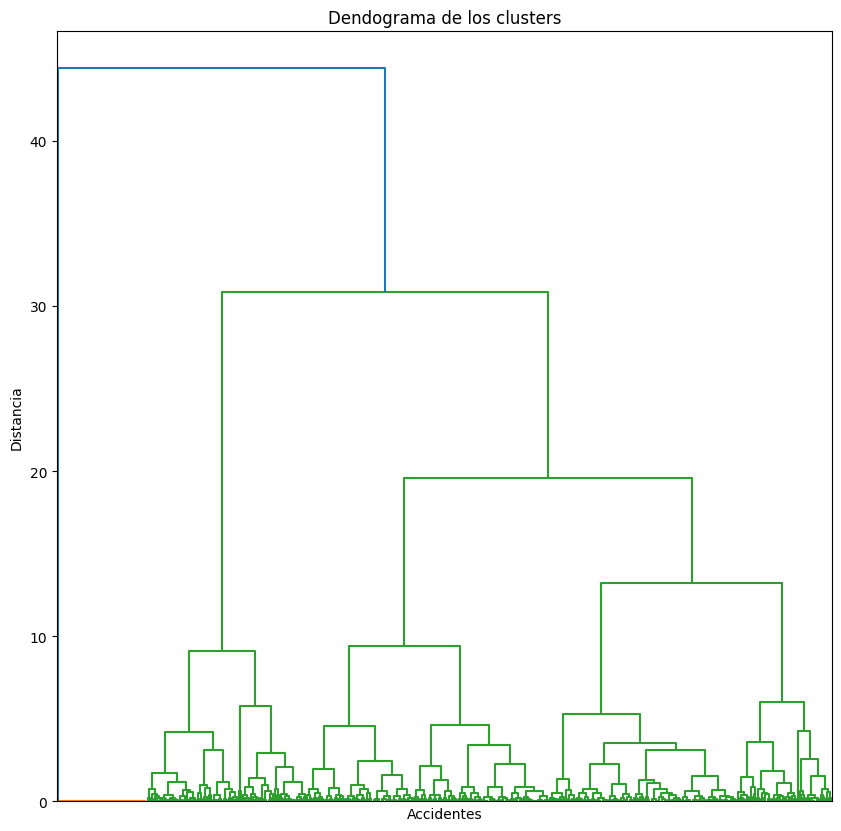

In [ ]:
plt.figure(figsize=(10, 10))
linkage_data = linkage(scaled_features ,method='ward')
dendrogram(linkage_data, no_labels= True)
plt.title('Dendograma de los clusters')
plt.xlabel('Accidentes')
plt.ylabel('Distancia')
plt.show()

Observamos una linea naranjada en el lado izquierdo del gráfico, ¿qué significa?

In [ ]:
df[["longitud","latitud"]].value_counts().iloc[0:3]

,,count
longitud,latitud,
-75.703816,6.221806,2626
-75.572664,6.276994,115
-75.574427,6.231878,65


Parece que existe un punto especifico que se repiten ¿2626 accidentes con heridos o muertos en un solo punto? ¿Esto tiene sentido?

¿Dónde esta ubicado este punto?

In [ ]:
df[["longitud","latitud"]].value_counts().iloc[0:3].index

MultiIndex([(-75.70381587, 6.22180566),
            (-75.57266356, 6.27699391),
            (-75.57442724,  6.2318775)],
           names=['longitud', 'latitud'])

In [ ]:
filtro_atipico= (df["longitud"]==-75.70381587)	& (df["latitud"]==6.22180566	)
df.loc[filtro_atipico, "Atípico"  ] ="Punto atípico"
fig = px.scatter_mapbox(df, lat="latitud", lon="longitud", color="Atípico")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

En el punto rojo se encuentran más de 2 mil accidentes de transito ocurridos en el 2021 ¿es normal?

In [ ]:
df.loc[filtro_atipico, "comuna"  ].value_counts()
df_new= df[~filtro_atipico ]

In [ ]:
df['comuna'].unique()
#Para borrar puntos atípicos:
df[df["comuna"].isin([" ","In", "Sin Inf"])]

array(['Laureles Estadio', 'La Candelaria', 'Castilla', 'Villa Hermosa',
       'Corregimiento de San Cristóbal', 'Santa Cruz', 'Buenos Aires',
       'Robledo', 'Manrique', 'Doce de Octubre', 'Sin inf', 'La América',
       'Aranjuez', 'Guayabal', 'Belén',
       'Corregimiento de San Antonio de Prado', ' ', 'El Poblado',
       'Popular', 'San Javier', 'In', 'Sin Inf',
       'Corregimiento de Santa Elena', 'Corregimiento De San Cristóbal',
       'Corregimiento De San Antonio De Prado', 'Doce De Octubre',
       'Corregimiento de Altavista',
       'Corregimiento de San Sebastián de Palmitas',
       'Corregimiento De Santa Elena', 'Corregimiento De Altavista', 'SN'],
      dtype=object)

Eliminemos el punto atípico, realicemos nuevamente el dendograma.

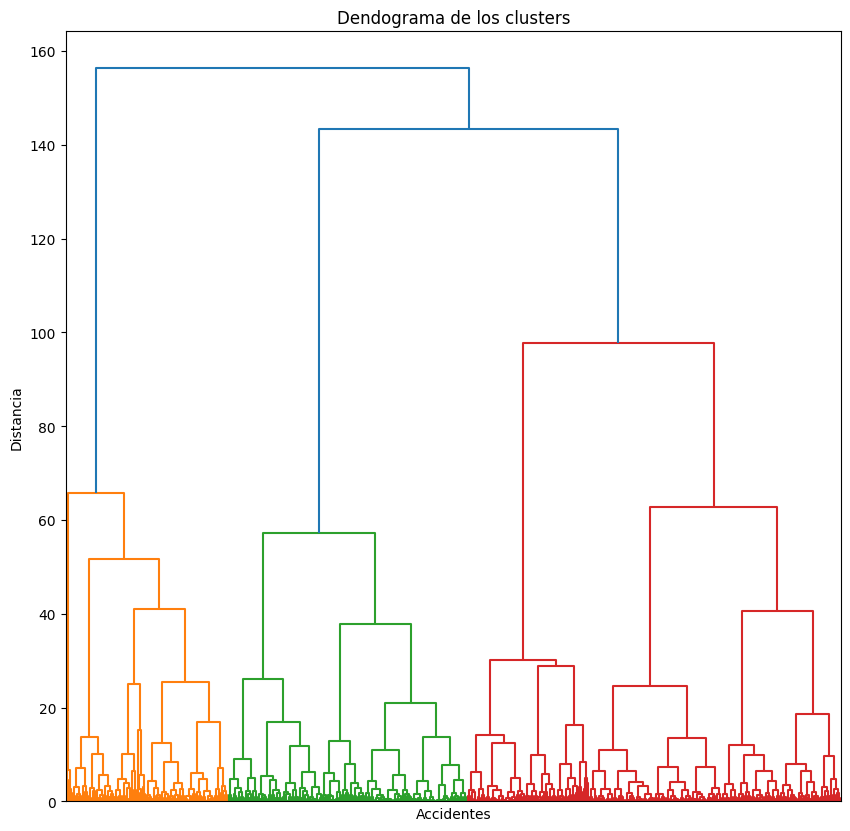

In [ ]:
columnas= ["longitud","latitud"] # seleccion de columnas
scaler = StandardScaler() # Algoritmo de estandarización
scaled_features = scaler.fit_transform(df_new[columnas]) # aplicando estandarización
scaled_features =pd.DataFrame(scaled_features, columns=columnas) # Transformando a data frame
plt.figure(figsize=(10, 10))
linkage_data = linkage(scaled_features ,method='ward') # creando dendograma
dendrogram(linkage_data, no_labels= True) # gráfica de dendograma
plt.title('Dendograma de los clusters')
plt.xlabel('Accidentes')
plt.ylabel('Distancia')
plt.show()

¿Cuál creen que podrá ser el número de clústeres aplicando clúster jerárquico?


¿Qué tal si utilizamos el método del codo y puntaje de silueta?

In [ ]:
from tqdm import tqdm
wcss = [] # valores de WCSS
silueta=[]
clusteres = range(2, 8)
for i in tqdm(clusteres):
  HC = AgglomerativeClustering(n_clusters=i) # Definir el algoritmo
  HC.fit(scaled_features[columnas])  # Entrenar el modelo
  scaled_features["cluster"] = HC.labels_ # Obtener las etiquetas
  centros= scaled_features.groupby("cluster")[columnas].mean()  # obteniendo centros
  argmin, distance =pairwise_distances_argmin_min(scaled_features[columnas],centros  )  # obteniendo distancias
  wcss.append(np.sum(distance) )
  silhouette_avg = silhouette_score(scaled_features[columnas], HC.labels_)
  silueta.append(silhouette_avg)


100%|██████████| 6/6 [03:12<00:00, 32.08s/it]


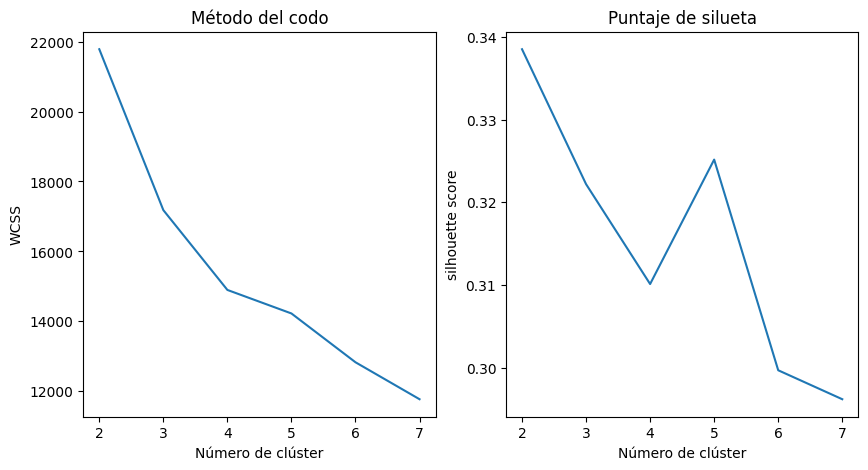

In [ ]:
clusteres = range(2, 8)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(clusteres,wcss)
axs[0].set_xlabel("Número de clúster" )
axs[0].set_ylabel("WCSS" )
axs[0].set_title("Método del codo")
axs[1].plot( clusteres,silueta)
axs[1].set_xlabel("Número de clúster" )
axs[1].set_ylabel("silhouette score" )
axs[1].set_title("Puntaje de silueta")
plt.show()

¿Cuál es el número de clústeres que ustedes elegirían?

In [ ]:
HC = AgglomerativeClustering(n_clusters=3) # Definir el algoritmo
HC.fit(scaled_features[columnas])  # Entrenar el modelo
df_new["cluster"] = HC.labels_ # Obtener las etiquetas
df_new["cluster"]= df_new["cluster"].astype(str) # Convertir a categoria

<ipython-input-21-33412b1b106f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-21-33412b1b106f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = px.scatter_mapbox(df_new, lat="latitud", lon="longitud", color="cluster")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Algo particular del clúster jerárquico, es que cuando tenemos 4 clústeres y luego aplicamos 5, uno de los clústeres será partido en dos.

In [ ]:
HC = AgglomerativeClustering(n_clusters=5) # Definir el algoritmo
HC.fit(scaled_features[columnas])  # Entrenar el modelo
df_new["cluster"] = HC.labels_ # Obtener las etiquetas
df_new["cluster"]= df_new["cluster"].astype(str) # Convertir a categoria

<ipython-input-25-a0dd15dd094b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-a0dd15dd094b>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = px.scatter_mapbox(df_new, lat="latitud", lon="longitud", color="cluster")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()